### 11763 Medical Image Processing 

Amelia Yolanda / May 2024

Objective 2: 3D Rigid Coregistration
- Coregister the given images using either landmarks or a function similarity measure. Implement the image coregistration yourself (i.e. without libraries such as PyElastix).
- Visualize the Thalamus region on the input image space.

In [52]:
import os
import matplotlib
import numpy as np
import scipy
import pydicom
import pandas as pd
import glob
import cv2

from matplotlib import pyplot as plt, animation
from scipy.optimize import least_squares, minimize
from scipy.ndimage import zoom
from skimage import exposure

In [2]:
# https://stackoverflow.com/questions/62159709/pydicom-read-file-is-only-working-with-some-dicom-images
#!pip install python-gdcm 

- Reference image: icbm avg 152 t1 tal nlin symmetric VI, of a T1 RM phantom in a normalized space.
- Input image: RM Brain 3D-SPGR, of an anonimized patient.


#### Load reference image

In [3]:
img_path = "./Project/icbm_avg_152_t1_tal_nlin_symmetric_VI.dcm"
ref_img = pydicom.dcmread(img_path)

print("Reference Image pixel_array shape: ", ref_img.pixel_array.shape)

reference_array = ref_img.pixel_array

Reference Image pixel_array shape:  (193, 229, 193)


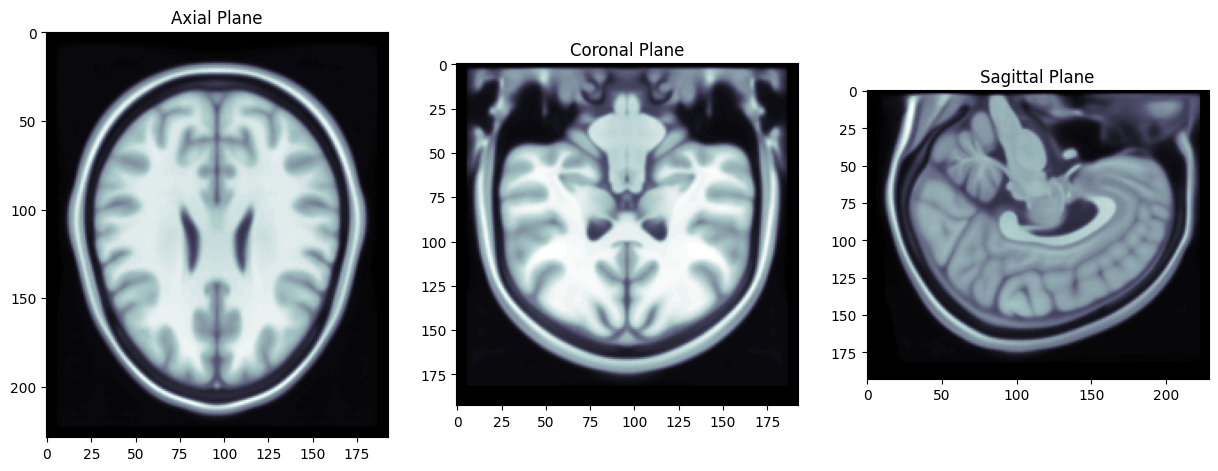

In [4]:
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(131)
ax1.set_title("Axial Plane")
ax1.imshow(ref_img.pixel_array[100, :, :], cmap='bone')

ax2 = fig.add_subplot(132)
ax2.set_title("Coronal Plane")
ax2.imshow(ref_img.pixel_array[:, 100, :], cmap='bone')

ax3 = fig.add_subplot(133)
ax3.set_title("Sagittal Plane")
ax3.imshow(ref_img.pixel_array[:, :, 100], cmap='bone')

#### Load patient data

In [5]:
ct_path = "./Project/RM_Brain_3D-SPGR/"

def extract_ct_data(ct_path_sort): # from obj 1, please bear with the naming
    ct_data = []
    ct_metadata = []

    for file in ct_path_sort:
        if file.endswith(".dcm"):
            path = os.path.join(ct_path, file)
            dataset = pydicom.dcmread(path)  # Load DICOM file
            #ct_data.append(dataset.pixel_array)
            ct_data.append(dataset)
            
            # Extract and append DICOM metadata to list
            ct_metadata.append({
                'AcquisitionNumber': dataset.AcquisitionNumber,
                'SliceIndex': dataset.InstanceNumber,
                'ImagePositionPatient': dataset.ImagePositionPatient,
                'ReferencedSegmentNumber': dataset.SOPInstanceUID,
                'SliceLocation': dataset.SliceLocation,
                'CTFile': file
            })
    # Convert metadata list to DataFrame
    metadata_df = pd.DataFrame(ct_metadata)
    return ct_data, metadata_df

In [6]:
# Ensure dataset in correct order
ct_path_sort = sorted(os.listdir(ct_path))

ct_data, ct_metadata = extract_ct_data(ct_path_sort)
print("Amount of patient file data: ", len(ct_data))

#ct_metadata.tail()

Amount of patient file data:  212


In [7]:
merge_data = {}

for file in ct_data:
    merge_data[float(file.SliceLocation)] = file.pixel_array

sorted_merge_data = {key:merge_data[key] for key in sorted(merge_data.keys())}
array_merge_data = np.array([i for i in sorted_merge_data.values()])

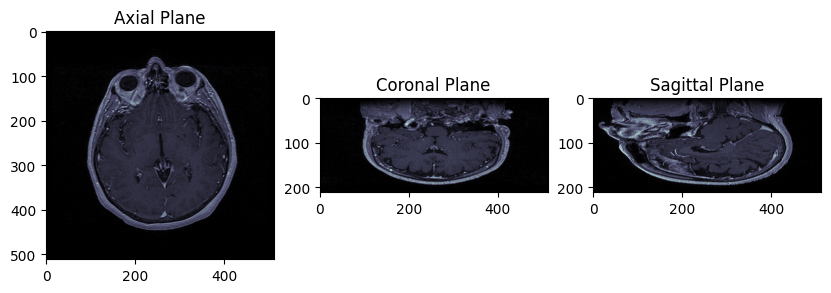

In [23]:
# Sample segmentation pixel_array
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(131)
ax1.set_title("Axial Plane")
ax1.imshow(array_merge_data[100, :, :], cmap='bone') # index from roughly half of shape

ax2 = fig.add_subplot(132)
ax2.set_title("Coronal Plane")
ax2.imshow(array_merge_data[:, 250, :], cmap='bone')

ax3 = fig.add_subplot(133)
ax3.set_title("Sagittal Plane")
ax3.imshow(array_merge_data[:, :, 250], cmap='bone')

#### Load AAL3 
(Automated Anatomical Labelling 3)

In [62]:
aal_path = "./Project/AAL3_1mm.dcm"
aal_img = pydicom.dcmread(aal_path)

print("AAL Image pixel_array shape: ", aal_img.pixel_array.shape)

aal_array = aal_img.pixel_array

AAL Image pixel_array shape:  (181, 217, 181)


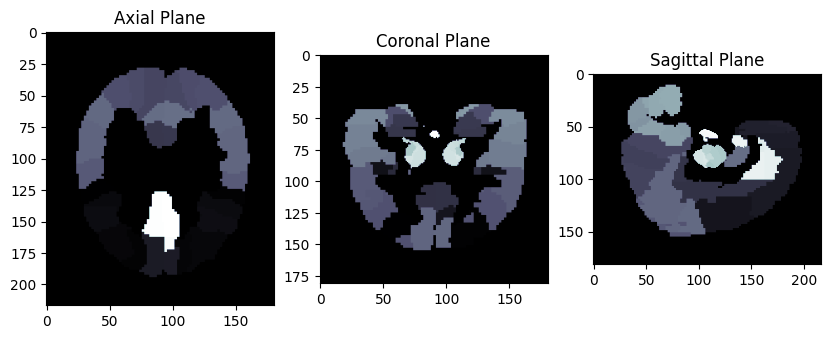

In [42]:
# Sample segmentation pixel_array
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(131)
ax1.set_title("Axial Plane")
ax1.imshow(aal_img.pixel_array[100, :, :], cmap='bone')

ax2 = fig.add_subplot(132)
ax2.set_title("Coronal Plane")
ax2.imshow(aal_img.pixel_array[:, 100, :], cmap='bone')

ax3 = fig.add_subplot(133)
ax3.set_title("Sagittal Plane")
ax3.imshow(aal_img.pixel_array[:, :, 100], cmap='bone')

In [61]:
print(f"Patient data shape: {ct_data[0].pixel_array.shape}")
print(f"Reference image shape: {ref_img.pixel_array.shape}")
print(f"AAL image shape: {aal_img.pixel_array.shape}")

Patient data shape: (512, 512)
Reference image shape: (193, 229, 193)
AAL image shape: (181, 217, 181)


#### Merge reference image, input image, and AAL image

In [44]:
pixel_len_mm = [ct_data[0].SliceThickness, ct_data[0].PixelSpacing[0], ct_data[0].PixelSpacing[1]]  # Pixel length in mm [z, y, x]
pixel_len_mm

['2.0', '0.5078', '0.5078']

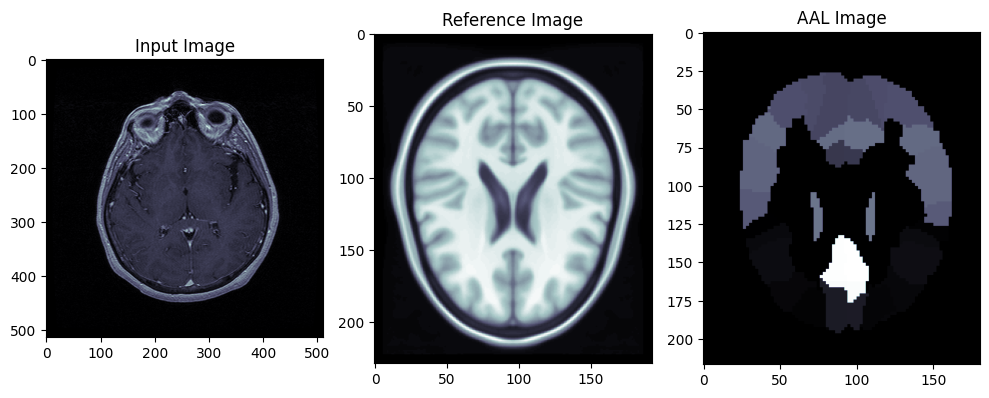

In [45]:
# Stack the input images, reference images, and segmentation masks into 3D arrays
input_volume = np.concatenate([img[np.newaxis, :] for img in array_merge_data], axis=0)
ref_volume = np.concatenate([img[np.newaxis, :] for img in reference_array], axis=0)
segmentation_volume = np.concatenate([img[np.newaxis, :] for img in aal_array], axis=0)

# Select an index for visualization
slice_index = 95 # roughly the middle plane

# Extract specific slices from each volume for visualization
input_slice = input_volume[slice_index + 10, :, :]
ref_slice = ref_volume[slice_index, :, :]
segmentation_slice = segmentation_volume[slice_index, :, :]

# Initialize a figure with three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(10, 8))

# Define the slices and their corresponding titles
slices = [input_slice, ref_slice, segmentation_slice]
titles = ["Input Image", "Reference Image", "AAL Image"]

# Plot each slice in a subplot
for idx, (slice_img, title) in enumerate(zip(slices, titles)):
    axes[idx].imshow(slice_img, cmap='bone')
    axes[idx].set_title(title)

# Display the plots
plt.tight_layout()
plt.show()


In [53]:
def get_thalamus_mask(img_atlas: np.ndarray) -> np.ndarray:
    thalamus_mask = np.zeros_like(img_atlas)
    thalamus_mask[(121 <= img_atlas) & (img_atlas <= 150)] = 1
    return thalamus_mask

def find_centroid(mask: np.ndarray) -> np.ndarray:
    # Your code here:
    #   Consider using `np.where` to find the indices of the voxels in the mask
    #   ...
    idcs = np.where(mask == 1)
    centroid = np.stack([
        np.mean(idcs[0]),
        np.mean(idcs[1]),
        np.mean(idcs[2]),
    ])
    return centroid

def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """Rotate the image on the axial plane."""
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

def normalize_intensity(input_image, reference_image):
    # Flatten the images to 1D arrays
    input_flat = input_image.flatten()
    reference_flat = reference_image.flatten()
    
    # Perform histogram matching
    matched_flat = exposure.match_histograms(input_flat, reference_flat)
    
    # Reshape the matched image back to its original shape
    matched_image = np.reshape(matched_flat, input_image.shape)
    return matched_image

def preprocess_landmarks(landmarks):
    max_value = np.max(landmarks)
    normalized_landmarks = landmarks / max_value
    preprocessed_landmarks = np.round(normalized_landmarks, 2) * 100
    return preprocessed_landmarks.astype(int)

In [55]:
# Reshape the phantom and AAL data 
img_phantom = ref_img.pixel_array[6:-6, 6:-7, 6:-6]     # Crop phantom to AAL size
aal_array = aal_array[:, :-1, :]     # Crop atlas size so that the sum of the shapes is divisible by 3

thalamus_mask = get_thalamus_mask(aal_array)
mask_centroid = find_centroid(thalamus_mask)
mask_centroid_idx = mask_centroid[0].astype('int')

# Reshape the input data (crop, zoom, and initial rotation)
input_data = array_merge_data
z_start = (input_data.shape[0] - 181) + 3 # adjust with the mask
z_end = z_start + 181
cropped_data = input_data[z_start:z_end, 48:456, 83:438]

resize_factors = (181 / cropped_data.shape[0], 216 / cropped_data.shape[1], 181 / cropped_data.shape[2])
zoom_data = zoom(cropped_data, resize_factors, order=1)
rotate_val = 3
rotated_data = rotate_on_axial_plane(zoom_data, rotate_val)
processed_input = normalize_intensity(rotated_data, img_phantom)
processed_input = preprocess_landmarks(processed_input)

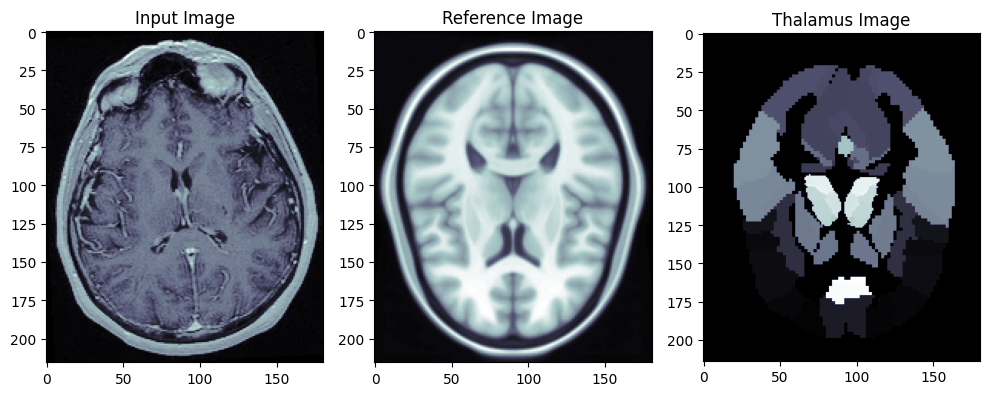

In [60]:
# Visualization after preprocessing
fig, ax = plt.subplots(1, 3, figsize=(10, 8))

images = [processed_input[mask_centroid_idx], img_phantom[mask_centroid_idx], aal_array[mask_centroid_idx]]
titles = ["Input Image", "Reference Image", "Thalamus Image"]

for i in range(3):
    ax[i].imshow(images[i], cmap='bone')
    ax[i].set_title(titles[i])

fig.tight_layout()
plt.show()
